<a href="https://colab.research.google.com/github/Mgalvaz/digit-recognizer/blob/main/train_quantum_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!pip install qiskit==1.4.3 qiskit-machine-learning==0.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 18.7 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567857 sha256=a2e1605f2f469df0188eeb65b5a3c345a2fe6637a3ee70757f4e2859b3b36372
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw


In [10]:
import numpy as np
from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.optimizers import COBYLA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import StatevectorSampler as Sampler
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
# Get a portion of the MNIST dataset and reduce the number of features
def preprocess_data(input_features, output_qubits, size_train=2000, test=0.25):
    size_test = int(size_train * test)
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    train_images = train_images.reshape((train_images.shape[0], -1)) / 255.0
    test_images = test_images.reshape((test_images.shape[0], -1)) / 255.0

    scaler = StandardScaler()
    train_images = scaler.fit_transform(train_images)
    test_images = scaler.transform(test_images)

    pca = PCA(n_components=input_features)
    train_images = pca.fit_transform(train_images)
    test_images = pca.transform(test_images)

    train_images = train_images * 2 * np.pi
    test_images = test_images * 2 * np.pi

    return (train_images[:size_train], train_labels[:size_train]), (test_images[:size_test], test_labels[:size_test])

In [4]:
def denseZZ_feature_map(num_features, param_name):
    num_qubits = num_features // 2
    qc = QuantumCircuit(num_qubits, name='Encoding')
    x = ParameterVector(param_name, length=num_features)
    for i in range(num_qubits):
        qc.ry(x[2 * i], i)
        qc.rz(x[2 * i + 1], i)
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
        qc.p(2 * (-np.pi + x[2 * i + 3]) * (-np.pi + x[2 * i + 1]), i + 1)
        qc.cx(i, i + 1)
    if num_qubits > 0:
        qc.cx(num_qubits - 1, 0)
        qc.p(2 * (-np.pi + x[1]) * (-np.pi + x[2 * num_qubits - 1]), 0)
        qc.cx(num_qubits - 1, 0)
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

def pool_circuit(origin, target, param_name):
    if len(origin) != len(target):
        raise ValueError('origin and target must be of the same length')
    num_qubits = len(origin) + len(target)
    params = ParameterVector(param_name, length=num_qubits // 2 * 3)
    qc = QuantumCircuit(num_qubits, name='Pooling Layer')
    for i, (o, t) in enumerate(zip(origin, target)):
        qc.rz(-np.pi / 2, t)
        qc.cx(t, o)
        qc.rz(params[3 * i], o)
        qc.ry(params[3 * i + 1], t)
        qc.cx(o, t)
        qc.ry(params[3 * i + 2], t)
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

def convolutional_circuit(num_qubits, parameter_name):
    qc = efficient_su2(num_qubits, reps=2, parameter_prefix=parameter_name, name='Convolutional Layer')
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

In [15]:
# Function that will execute at the end of each iteration
def callback_func(weights, loss):
    losses.append(loss)
    if len(losses)%10 == 0:
      clear_output(wait=True)
      plt.title("Loss against iteration")
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.plot(range(len(losses)), losses)
      plt.show()

def interpreter(x):
    #return int(format(x, '04b')[-4:], base=2)
    return x%10

In [16]:
# Feature map to encode classical data into qubits
feature_map = denseZZ_feature_map(16, 'x')

# VQC ansatz composed of convolutional with pooling layers
ansatz = QuantumCircuit(8)
ansatz.compose(convolutional_circuit(8, 'c1'), range(8), inplace=True)
ansatz.compose(pool_circuit(range(4), range(4, 8), 'p1'), range(8), inplace=True)
ansatz.compose(convolutional_circuit(4, 'c2'), range(4, 8), inplace=True)

# Full circuit
QCNN = QuantumCircuit(8)
QCNN.compose(feature_map, range(8), inplace=True)
QCNN.compose(ansatz, range(8), inplace=True)

qnn = SamplerQNN(
    circuit=QCNN.decompose(),
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=interpreter,
    output_shape=10,
    sampler=Sampler()
)

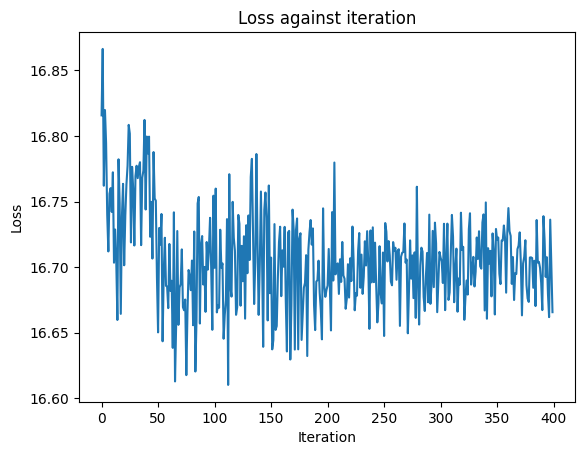

0.064

In [18]:
losses = []
classifier = NeuralNetworkClassifier(qnn, optimizer=COBYLA(maxiter=400), callback=callback_func)
(train_x, train_y), (test_x, test_y) = preprocess_data(16,4, size_train=500)

classifier.fit(train_x, train_y)
classifier.score(test_x, test_y)